# 3.6.5 Cancer Diagnostics

Using set of breast cancer data, create a model to predict breast cancer. Also, what traits are most indicative of whether or not an individual will be diagnosed?

__Data Source__: Kaggle Data Set

__Description__:This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg. The dataset we are using here is slightly different from the original one.

1. Title: Wisconsin Breast Cancer Database (January 8, 1991)

2. Sources:
   - Dr. WIlliam H. Wolberg (physician)
      University of Wisconsin Hospitals
      Madison, Wisconsin
      USA
   - Donor: Olvi Mangasarian (mangasarian@cs.wisc.edu)
      Received by David W. Aha (aha@cs.jhu.edu)
   - Date: 15 July 1992


3. Number of Instances: 699 (as of 15 July 1992)

4. Number of Attributes: 10 plus the class attribute

5. Attribute Information:

   - Sample code number            
   - Clump Thickness               
   - Uniformity of Cell Size       
   - Uniformity of Cell Shape      
   - Marginal Adhesion            
   - Single Epithelial Cell Size   
   - Bare Nuclei                   
   - Bland Chromatin               
   - Normal Nucleoli               
   - Mitoses                       
   - Class:                      

6. Missing attribute values: 16

7. Class distribution:
 
   - Benign: 458 (65.5%)
   - Malignant: 241 (34.5%)

In [1]:
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

### Data exploration

In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
                  header=None,
                 names=['ID_number', 'Diagnosis', 
                     'mean_radius','mean_texture', 'mean_perimeter','mean_area','mean_smoothness',
                  'mean_compactness','mean_concavity','mean_concave points','mean_symmetry','mean_fractal_dimension',
                          'se_radius','se_texture', 'se_perimeter','se_area','se_smoothness',
                  'se_compactness','se_concavity','se_concave points','se_symmetry','se_fractal_dimension',
                          'largest_radius','largest_texture', 'largest_perimeter','largest_area','largest_smoothness',
                  'largest_compactness','largest_concavity','largest_concave points','largest_symmetry','largest_fractal_dimension'])

In [3]:
print ("Shape of data: ", df.shape)
display(df.head(5))

Shape of data:  (569, 32)


,ID_number,Diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave points,...,largest_radius,largest_texture,largest_perimeter,largest_area,largest_smoothness,largest_compactness,largest_concavity,largest_concave points,largest_symmetry,largest_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.isnull().sum()

ID_number                    0
Diagnosis                    0
mean_radius                  0
mean_texture                 0
mean_perimeter               0
mean_area                    0
mean_smoothness              0
mean_compactness             0
mean_concavity               0
mean_concave points          0
mean_symmetry                0
mean_fractal_dimension       0
se_radius                    0
se_texture                   0
se_perimeter                 0
se_area                      0
se_smoothness                0
se_compactness               0
se_concavity                 0
se_concave points            0
se_symmetry                  0
se_fractal_dimension         0
largest_radius               0
largest_texture              0
largest_perimeter            0
largest_area                 0
largest_smoothness           0
largest_compactness          0
largest_concavity            0
largest_concave points       0
largest_symmetry             0
largest_fractal_dimension    0
dtype: i

/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


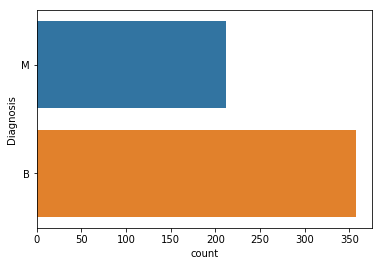

B    357
M    212
Name: Diagnosis, dtype: int64


In [5]:
sns.countplot(y='Diagnosis', data=df)
plt.show()
print(df.Diagnosis.value_counts())

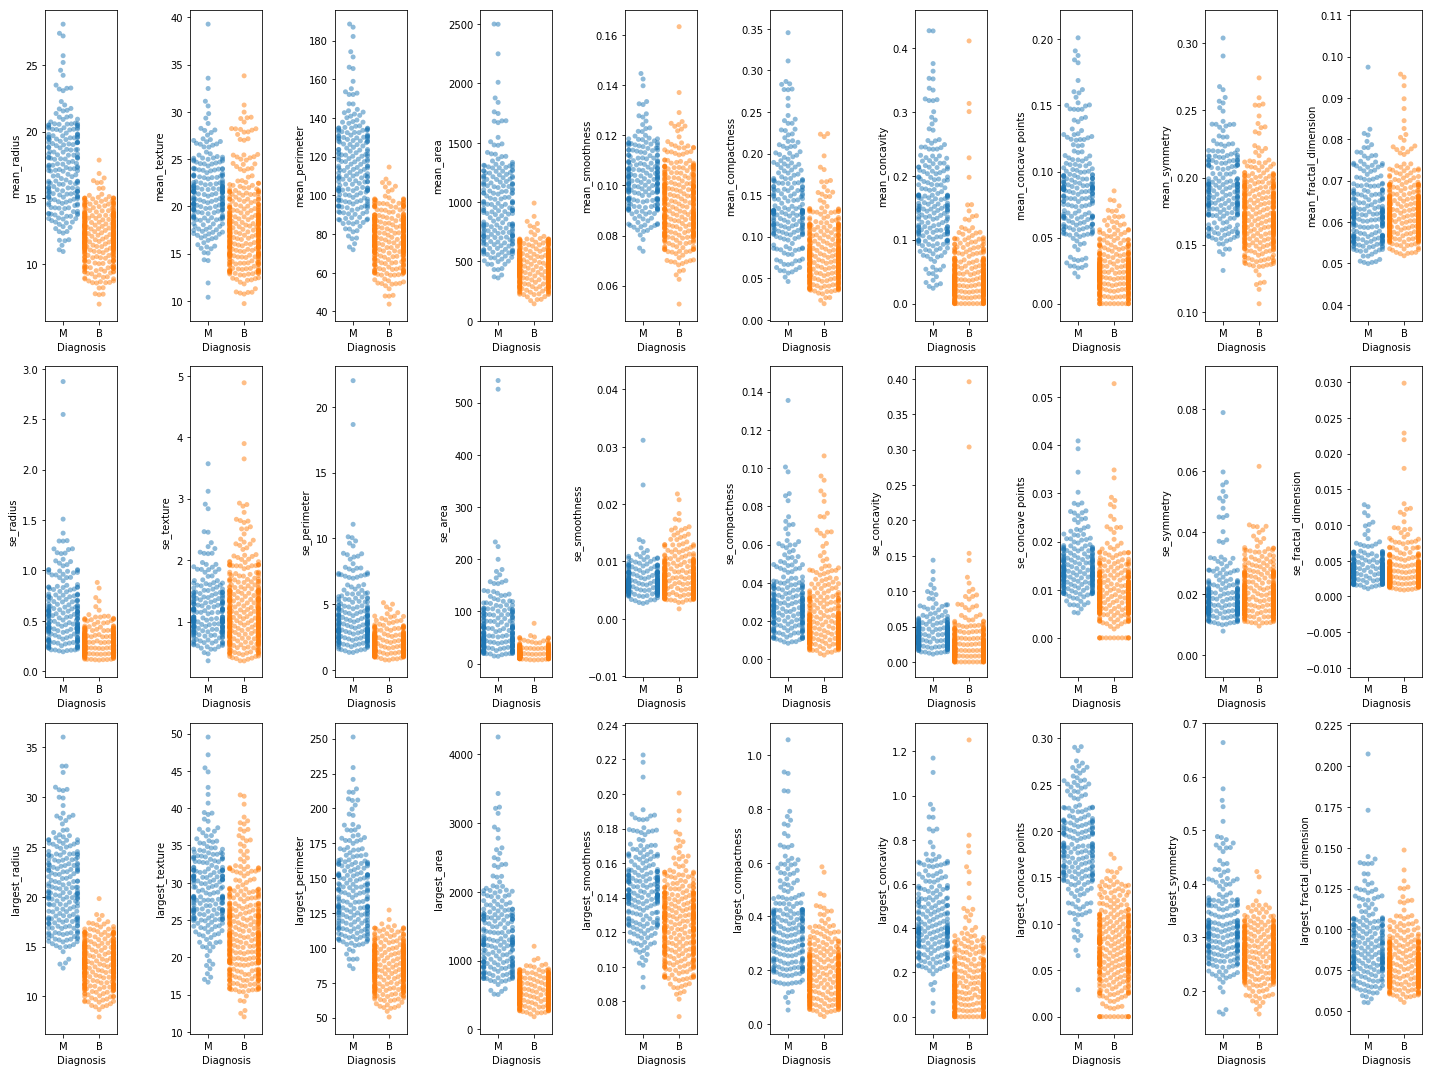

In [6]:
plt.figure(figsize=(20,15))
i=1
p_vals = pd.DataFrame(columns=['Attribute', 'MB_P-value'])
for col in df.columns.drop(['Diagnosis', 'ID_number']):
    plt.subplot(3,10,i)
    sns.swarmplot(x='Diagnosis', y=col, data=df, alpha=0.5)
    t_val, p_val = ttest_ind(df[df['Diagnosis']=='M'][col],
                            df[df['Diagnosis']=='B'][col])
    p_vals = p_vals.append({'Attribute':col, 'MB_P-value':float(p_val)}, 
                                    ignore_index=True)
    i+=1
plt.tight_layout()
plt.show()

In [7]:
p_vals.sort_values('MB_P-value', ascending=False)

,Attribute,MB_P-value
18,se_symmetry,8.766418e-01
11,se_texture,8.433320e-01
9,mean_fractal_dimension,7.599368e-01
14,se_smoothness,1.102966e-01
19,se_fractal_dimension,6.307355e-02
16,se_concavity,8.260176e-10
15,se_compactness,9.975995e-13
29,largest_fractal_dimension,2.316432e-15
8,mean_symmetry,5.733384e-16
4,mean_smoothness,1.051850e-18


## Feature Selection

We drop the most statistcally correlated feautres from the dataset, as a result of the latter p-values, and create a categorical column for Diagnosis.

In [8]:
features = df.drop(['ID_number', 'Diagnosis', 'se_symmetry',
                    'se_texture', 'mean_fractal_dimension',
                    'se_smoothness'], axis=1)
features['Diagnosis'] = df.Diagnosis.map(lambda x: 0 if x=='B' else 1)
features.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave points,mean_symmetry,se_radius,...,largest_texture,largest_perimeter,largest_area,largest_smoothness,largest_compactness,largest_concavity,largest_concave points,largest_symmetry,largest_fractal_dimension,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


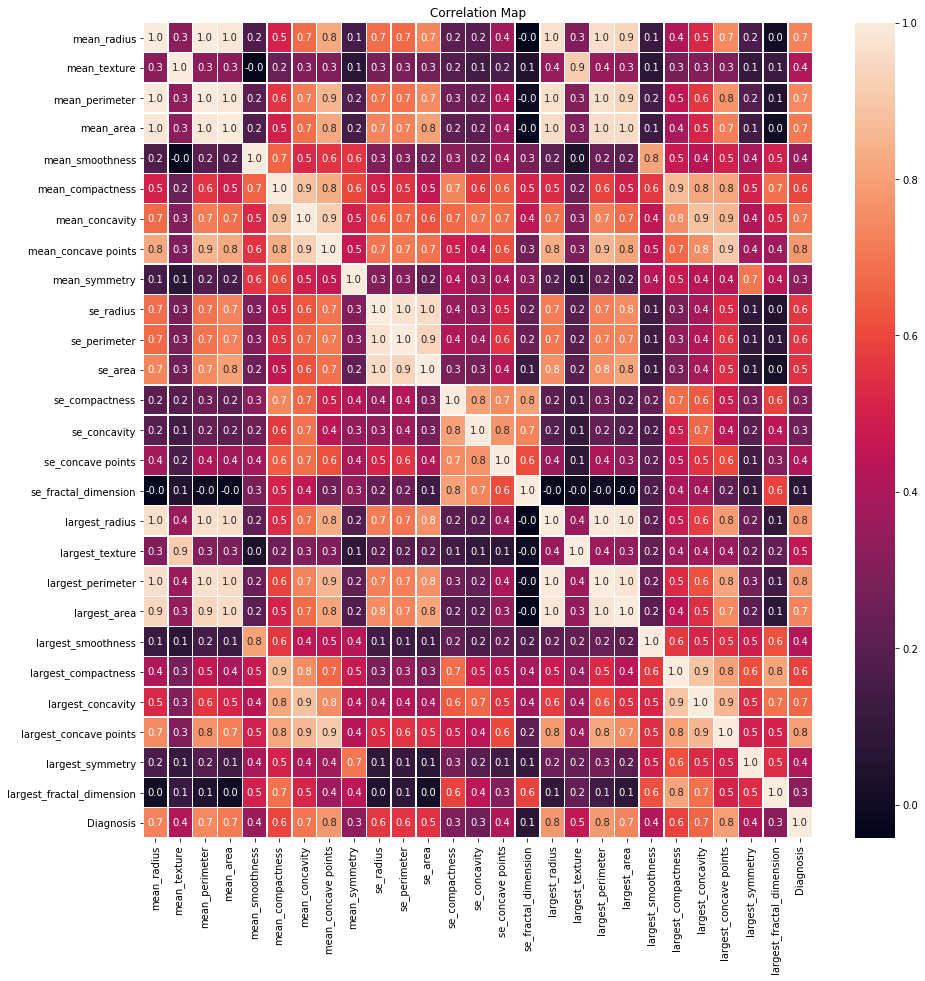

In [9]:
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(features.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

- The range of this numbers are -1 to 1.
- Meaning of 1 is two variable are positively correlated with each other.
- Meaning of zero is there is no correlation between variables like radius mean and fractal dimension se
- Meaning of -1 is two variables are negatively correlated with each other.

We can see that there is a strong correlation between the mean, standard error, and largest values for the tumors. There is also a strong positive correlation between the diagnosis and each feature.

From the correlation matrix I chose the following features with a value equal or greater than 0.8 with respect to Diagnosis for furter modeling. These features are:

- Mean Concave Points
- Largest Radius
- Largest Perimeter
- Largest Concave Points

In [10]:
df_models = df[['mean_concave points', 'largest_radius', 'largest_perimeter', 'largest_concave points']]

In [11]:
#Normalizing
#Check reference: https://stackoverflow.com/questions/12525722/normalize-data-in-pandas/12525836
df_norm = (df_models - df_models.min()) / (df_models.max() - df_models.min())
display(df_norm.head(1))

,mean_concave points,largest_radius,largest_perimeter,largest_concave points
0,0.731113,0.620776,0.66831,0.912027


In [12]:
# Input and outcome variables
X = df_norm
Y = features['Diagnosis']

## Models

In [13]:
df_eval = pd.DataFrame()
evals = np.zeros(3)

# Holdout: split fraud and non_fraud
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#### Holdout groups

- X_train
- X_test
- Y_train
- Y_test

In [14]:
# Baseline
start = time.time()
base_pred = np.zeros(len(Y_test) - 1)
base_pred = np.append(base_pred, 1)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.00


### KNN

In [15]:
# KNN Classifier
start = time.time()
knn_model = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', n_jobs = 5)
knn_model.fit(X_train, Y_train)
knn_pred = knn_model.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.14


             precision    recall  f1-score   support

     Benign       1.00      1.00      1.00       284
  Malignant       1.00      1.00      1.00       171

avg / total       1.00      1.00      1.00       455



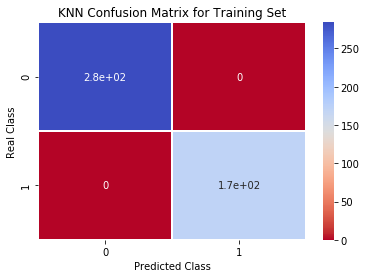

In [16]:
# Print classification report
Y_pred_knn = knn_model.predict(X_train)
print(classification_report(Y_train, Y_pred_knn, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_knn = confusion_matrix(Y_train, Y_pred_knn)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_knn, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('KNN Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

             precision    recall  f1-score   support

     Benign       0.96      0.96      0.96        73
  Malignant       0.93      0.93      0.93        41

avg / total       0.95      0.95      0.95       114



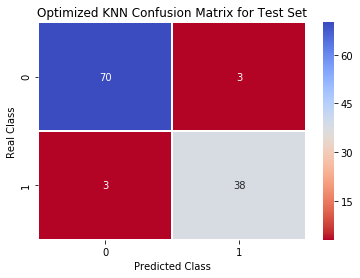

Cross Validation Accuracy Scores: 0.929(+/- 0.16)


In [17]:
y_pred_knn2_test = knn_model.predict(X_test)
#printing classification report
print(classification_report(Y_test, y_pred_knn2_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_knn_test = confusion_matrix(Y_test, y_pred_knn2_test)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_knn_test,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Optimized KNN Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_knn2t = cross_val_score(knn_model, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_knn2t.mean(), 
                                                                      (scores_knn2t.std())*2))

### Random Forest

In [18]:
# RandomForestClassifier 
start = time.time()
rfc = ensemble.RandomForestClassifier(n_jobs = 3)
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.22


             precision    recall  f1-score   support

     Benign       0.99      1.00      0.99       284
  Malignant       0.99      0.99      0.99       171

avg / total       0.99      0.99      0.99       455



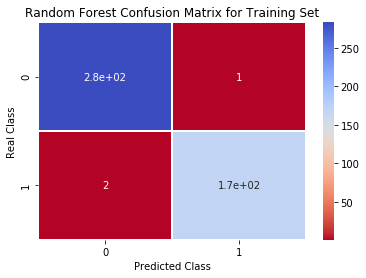

In [19]:
# Print classification report
Y_pred_rfc = rfc.predict(X_train)
print(classification_report(Y_train, Y_pred_rfc, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_rfc = confusion_matrix(Y_train, Y_pred_rfc)

# Creating heatmap of confusion matrix
sns.heatmap(conf_matrix_rfc, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Random Forest Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

We can see from the classification report that this model is extremely oferfit. Hence, we'll use GridSearCV to optimize our model.

In [20]:
parameters = {'n_estimators':[10,100,500],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False],
             'max_depth':[4,5,6,7,8]}
grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5)
grid_rfc.fit(X_train, Y_train)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

0.947252747253
{'bootstrap': True, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 10}


             precision    recall  f1-score   support

     Benign       0.97      0.97      0.97       284
  Malignant       0.95      0.95      0.95       171

avg / total       0.96      0.96      0.96       455



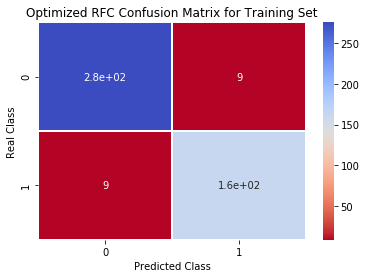

Cross Validation Accuracy Scores: 0.930(+/- 0.09)


In [21]:
# Instantiating model with best parameters

best_params_rfc = grid_rfc.best_params_
rfc2 = RandomForestClassifier(**best_params_rfc)
rfc2.fit(X_train, Y_train)
y_pred_rfc2 = rfc2.predict(X_train)

#Printing classification report

print(classification_report(Y_train, y_pred_rfc2, target_names=['Benign', 'Malignant']))

#Building confusion matrix

conf_matrix_train_rfc2 = confusion_matrix(Y_train, y_pred_rfc2)

# Creating heatmap of confusion matrix

sns.heatmap(conf_matrix_train_rfc2,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Optimized RFC Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rfc2 = cross_val_score(rfc2, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfc2.mean(), 
                                                                      scores_rfc2.std()*2))

Applying our refined model to the test set

             precision    recall  f1-score   support

     Benign       0.97      0.96      0.97        73
  Malignant       0.93      0.95      0.94        41

avg / total       0.96      0.96      0.96       114



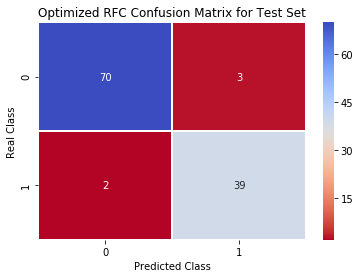

Cross Validation Accuracy Scores: 0.939(+/- 0.11)


In [22]:
y_pred_rfc2_test = rfc2.predict(X_test)
#printing classification report
print(classification_report(Y_test, y_pred_rfc2_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_rfc2_test = confusion_matrix(Y_test, y_pred_rfc2_test)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_rfc2_test,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Optimized RFC Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rfc2t = cross_val_score(rfc2, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfc2t.mean(), 
                                                                      (scores_rfc2t.std())*2))

### Logistic Regression

In [23]:
# Logistic Regression
start = time.time()
log_reg_model = linear_model.LogisticRegression(penalty = 'l2', C=1e9)
log_reg_model.fit(X_train, Y_train)
log_reg_pred = log_reg_model.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.21


             precision    recall  f1-score   support

     Benign       0.95      0.96      0.96       284
  Malignant       0.93      0.92      0.93       171

avg / total       0.95      0.95      0.95       455



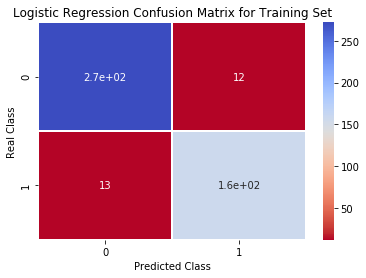

Cross Validation Accuracy Scores: 0.941(+/- 0.06)


In [24]:
#printing classification report
print(classification_report(Y_train, log_reg_pred, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_logR = confusion_matrix(Y_train, log_reg_pred)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_logR,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Logistic Regression Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_logR = cross_val_score(log_reg_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_logR.mean(), 
                                                                      scores_logR.std()*2))

             precision    recall  f1-score   support

     Benign       0.97      0.97      0.97        73
  Malignant       0.95      0.95      0.95        41

avg / total       0.96      0.96      0.96       114



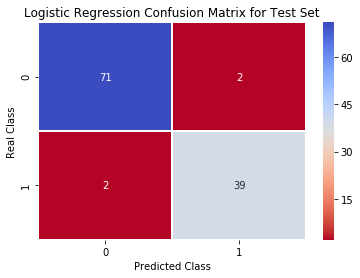

Cross Validation Accuracy Scores: 0.956(+/- 0.12)


In [25]:
#predicting for the test set
y_pred_logR_test = log_reg_model.predict(X_test)

#printing classification report
print(classification_report(Y_test, y_pred_logR_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_test_logR = confusion_matrix(Y_test, y_pred_logR_test)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_test_logR,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Logistic Regression Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_logRt = cross_val_score(log_reg_model, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_logRt.mean(), 
                                                                      scores_logRt.std()*2))

In [26]:
parameters2 = [{'C':[0.1,1,10,100,500,800], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100,500,800], 'solver':['newton-cg'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100,500,800], 'solver':['liblinear'], 'fit_intercept':[True], 'penalty':['l1', 'l2']}]
grid_logR = GridSearchCV(estimator=log_reg_model, param_grid=parameters2)
grid_logR.fit(X_train, Y_train)
print(grid_logR.best_score_)
print(grid_logR.best_params_)

0.947252747253
{'C': 500, 'fit_intercept': True, 'solver': 'lbfgs'}


In [27]:
#identifying best values
best_params = grid_logR.best_params_

#instantiatng and fitting logistic regression model with default values
logR2 = linear_model.LogisticRegression(penalty = 'l2', **best_params)
logR2.fit(X_train, Y_train)
scores_logR2 = cross_val_score(logR2, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_logR2.mean(), 
                                                                                 scores_logR2.std()*2))
scores_logR2t = cross_val_score(logR2, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_logR2t.mean(), 
                                                                                 scores_logR2t.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.939(+/- 0.08)
Cross Validation Accuracy Scores - Test Set: 0.956(+/- 0.12)


### Ridge Classifier

In [28]:
# Ridge Classifier
start = time.time()
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(X_train, Y_train)
ridge_pred = ridge_model.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.30


             precision    recall  f1-score   support

     Benign       0.92      1.00      0.96       284
  Malignant       0.99      0.85      0.92       171

avg / total       0.95      0.94      0.94       455



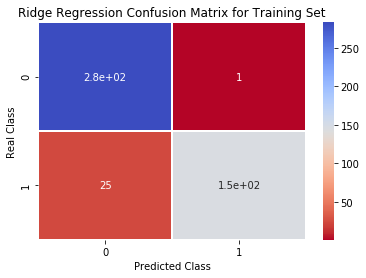

Cross Validation Accuracy Scores: 0.936(+/- 0.08)


In [29]:
#printing classification report
print(classification_report(Y_train, ridge_pred, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_ridge = confusion_matrix(Y_train, ridge_pred)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_ridge, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Ridge Regression Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_Ridge = cross_val_score(ridge_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_Ridge.mean(), 
                                                                      scores_Ridge.std()*2))


             precision    recall  f1-score   support

     Benign       0.94      1.00      0.97        73
  Malignant       1.00      0.88      0.94        41

avg / total       0.96      0.96      0.96       114



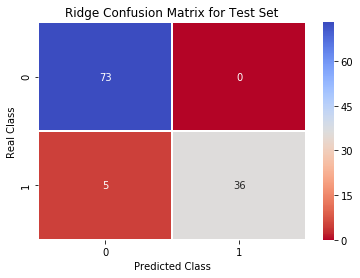

Cross Validation Accuracy Scores: 0.947(+/- 0.09)


In [30]:
#predicting for the test set
y_pred_Ridge_test = ridge_model.predict(X_test)

#printing classification report
print(classification_report(Y_test, y_pred_Ridge_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_test_Ridge = confusion_matrix(Y_test, y_pred_Ridge_test)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_test_Ridge,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Ridge Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_RidgeTest = cross_val_score(ridge_model, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_RidgeTest.mean(), 
                                                                      scores_RidgeTest.std()*2))

In [31]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

grid_Ridge = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alphas))
grid_Ridge.fit(X_train, Y_train)
print(grid_Ridge.best_score_)
print(grid_Ridge.best_params_)

0.938461538462
{'alpha': 0.01}


In [32]:
#identifying best values
best_params = grid_Ridge.best_params_

#instantiatng and fitting logistic regression model with default values
Ridge2 = linear_model.RidgeClassifier(**best_params)
Ridge2.fit(X_train, Y_train)
scores_Ridge2 = cross_val_score(Ridge2, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_Ridge2.mean(), 
                                                                                 scores_Ridge2.std()*2))
scores_Ridge2Test = cross_val_score(Ridge2, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_Ridge2Test.mean(), 
                                                                                 scores_Ridge2Test.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.936(+/- 0.07)
Cross Validation Accuracy Scores - Test Set: 0.938(+/- 0.12)


### Lasso Classifier

In [33]:
#https://stackoverflow.com/questions/41639557/how-to-perform-logistic-lasso-in-python

# Lasso Classifier
start = time.time()
lasso_model = linear_model.LogisticRegression(penalty = 'l1')
lasso_model.fit(X_train, Y_train)
lasso_pred = lasso_model.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.01


             precision    recall  f1-score   support

     Benign       0.94      0.97      0.95       284
  Malignant       0.94      0.90      0.92       171

avg / total       0.94      0.94      0.94       455



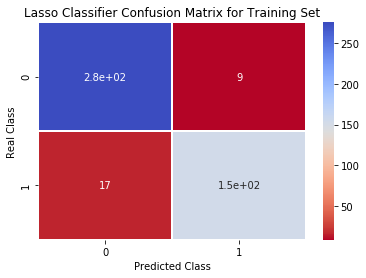

Cross Validation Accuracy Scores: 0.938(+/- 0.07)


In [34]:
#printing classification report
print(classification_report(Y_train, lasso_pred, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_train_lasso = confusion_matrix(Y_train, lasso_pred)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_train_lasso, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Lasso Classifier Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_Lasso = cross_val_score(lasso_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_Lasso.mean(), 
                                                                      scores_Lasso.std()*2))

             precision    recall  f1-score   support

     Benign       0.95      0.97      0.96        73
  Malignant       0.95      0.90      0.92        41

avg / total       0.95      0.95      0.95       114



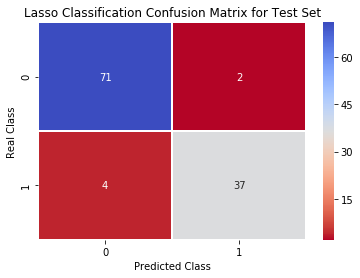

Cross Validation Accuracy Scores: 0.947(+/- 0.09)


In [35]:
#predicting for the test set
y_pred_Lasso_test = lasso_model.predict(X_test)

#printing classification report
print(classification_report(Y_test, y_pred_Lasso_test, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_test_Lasso = confusion_matrix(Y_test, y_pred_Lasso_test)
#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_test_Lasso,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Lasso Classification Confusion Matrix for Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_LassoTest = cross_val_score(lasso_model, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_LassoTest.mean(), 
                                                                      scores_LassoTest.std()*2))

### SVC Classifier

In [36]:
# SVClassifier
start = time.time()
svc_model = svm.SVC(C = 100, kernel = 'rbf')
svc_model.fit(X_train, Y_train)
svc_pred = svc_model.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.05


             precision    recall  f1-score   support

     Benign       0.95      0.98      0.96       284
  Malignant       0.96      0.91      0.94       171

avg / total       0.95      0.95      0.95       455



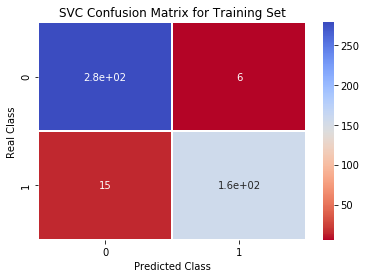

Cross Validation Accuracy Scores - Training Set: 0.936(+/- 0.08)
Cross Validation Accuracy Scores - Test Set: 0.947(+/- 0.12)


In [37]:
#printing classification report
print(classification_report(Y_train, svc_pred, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_svc = confusion_matrix(Y_train, svc_pred)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_svc,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('SVC Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_svc = cross_val_score(svc_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_svc.mean(), 
                                                                                 scores_svc.std()*2))
scores_svct = cross_val_score(svc_model, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svct.mean(), 
                                                                                 scores_svct.std()*2))

In [38]:
parameters = [{'kernel':['rbf'], 'C':[0.01,0.1,1,10,20], 'gamma':[1e-4, 1e-3, 1e-2]},
              {'kernel':['linear'], 'C':[0.01,0.1,1,10,20]},
             {'kernel':['poly'], 'C':[0.01,0.1,1,10,20], 'gamma':[1e-4, 1e-3, 1e-2]}]
#fitting model and printing best parameters and score from model
grid_svc = GridSearchCV(svc_model, param_grid=parameters)
grid_svc.fit(X_train, Y_train)
print(grid_svc.best_params_)
print(grid_svc.best_score_)

{'C': 1, 'kernel': 'linear'}
0.938461538462


In [39]:
#using best paramteres to fit and test accuracy of train and test sets
best_params_svc = grid_svc.best_params_
svc2 = svm.SVC(**best_params_svc)
svc2.fit(X_train, Y_train)

scores_svc2 = cross_val_score(svc2, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_svc2.mean(), 
                                                                                 scores_svc2.std()*2))
scores_svc2t = cross_val_score(svc2, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svc2t.mean(), 
                                                                                 scores_svc2t.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.940(+/- 0.07)
Cross Validation Accuracy Scores - Test Set: 0.965(+/- 0.09)


### Gradient Boost Classifier

In [40]:
# Gradient Boost Classifier
start = time.time()
params = {'n_estimators': 1000,
          'max_depth': 2,
          'learning_rate': 0.001,
          'loss': 'deviance'}
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, Y_train)
gbc_pred = gbc.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.67


             precision    recall  f1-score   support

     Benign       0.95      0.99      0.97       284
  Malignant       0.97      0.91      0.94       171

avg / total       0.96      0.96      0.96       455



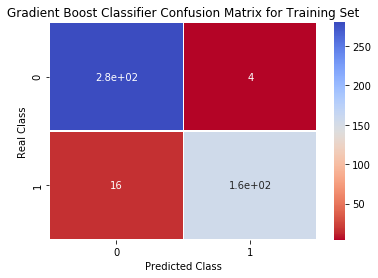

Cross Validation Accuracy Scores - Training Set: 0.925(+/- 0.09)
Cross Validation Accuracy Scores - Test Set: 0.965(+/- 0.09)


In [41]:
#printing classification report
print(classification_report(Y_train, gbc_pred, target_names=['Benign', 'Malignant']))

#building confusion matrix
conf_matrix_gbc = confusion_matrix(Y_train, gbc_pred)

#creating heatmap of confusion matrix
sns.heatmap(conf_matrix_gbc, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Gradient Boost Classifier Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_gbc = cross_val_score(gbc, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_gbc.mean(), 
                                                                                 scores_gbc.std()*2))
scores_gbct = cross_val_score(gbc, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_gbct.mean(), 
                                                                                 scores_gbct.std()*2))

In [42]:
parameters = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              'max_features': [1.0, 0.3, 0.1] 
              }

#fitting model and printing best parameters and score from model
grid_gbc = GridSearchCV(gbc, param_grid=parameters)
grid_gbc.fit(X_train, Y_train)
print(grid_gbc.best_params_)
print(grid_gbc.best_score_)

{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 20}
0.934065934066


In [43]:
#using best paramteres to fit and test accuracy of train and test sets
best_params_gbc = grid_gbc.best_params_
gbc2 = ensemble.GradientBoostingClassifier(**best_params_gbc)
gbc2.fit(X_train, Y_train)

scores_gbc2 = cross_val_score(gbc2, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_gbc2.mean(), 
                                                                                 scores_gbc2.std()*2))
scores_gbc2t = cross_val_score(gbc2, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_gbc2t.mean(), 
                                                                                 scores_gbc2t.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.921(+/- 0.10)
Cross Validation Accuracy Scores - Test Set: 0.930(+/- 0.13)


## Evaluation

In [44]:
print('KNN Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_knn2t.mean(), 
                                                                      (scores_knn2t.std())*2))

print('Random Forest ClassificationCross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfc2t.mean(), 
                                                                      (scores_rfc2t.std())*2))

print('Logistic RegressionCross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_logR2t.mean(), 
                                                                                 scores_logR2t.std()*2))

print('Ridge Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_Ridge2Test.mean(), 
                                                                                 scores_Ridge2Test.std()*2))

print('Lasso Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_LassoTest.mean(), 
                                                                      scores_LassoTest.std()*2))

print('SVC Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svc2t.mean(), 
                                                                                 scores_svc2t.std()*2))

print('Gradient Boost Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_gbc2t.mean(), 
                                                                                 scores_gbc2t.std()*2))

KNN Cross Validation Accuracy Scores: 0.929(+/- 0.16)
Random Forest ClassificationCross Validation Accuracy Scores: 0.939(+/- 0.11)
Logistic RegressionCross Validation Accuracy Scores - Test Set: 0.956(+/- 0.12)
Ridge Cross Validation Accuracy Scores - Test Set: 0.938(+/- 0.12)
Lasso Cross Validation Accuracy Scores: 0.947(+/- 0.09)
SVC Cross Validation Accuracy Scores - Test Set: 0.965(+/- 0.09)
Gradient Boost Cross Validation Accuracy Scores - Test Set: 0.930(+/- 0.13)


#### F1 Score

In [45]:
y_pred_Lasso_test = lasso_model.predict(X_test)
y_pred_logR2_test = logR2.predict(X_test)
y_pred_Ridge2_test = Ridge2.predict(X_test)
y_pred_svc2_test = svc2.predict(X_test)
y_pred_gbv2_test = gbc2.predict(X_test)

In [46]:
from sklearn.metrics import f1_score

#printing F1 scores for reach model's predicted values
print('F1 score for KNN: {}'. format(f1_score(Y_test, y_pred_knn2_test)))
print('F1 score for Random Forest Classification: {}'. format(f1_score(Y_test, y_pred_rfc2_test)))
print('F1 score for Logistic Regression: {}'.format(f1_score(Y_test, y_pred_logR2_test)))
print('F1 score for Ridge Regression: {}'.format(f1_score(Y_test, y_pred_Ridge2_test)))
print('F1 score for Lasso Regression: {}'.format(f1_score(Y_test, y_pred_Lasso_test)))
print('F1 score for SVC Classification: {}'. format(f1_score(Y_test, y_pred_svc2_test)))
print('F1 score for Gradient Boost: {}'. format(f1_score(Y_test, y_pred_gbv2_test)))

F1 score for KNN: 0.926829268292683
F1 score for Random Forest Classification: 0.9397590361445782
F1 score for Logistic Regression: 0.9512195121951219
F1 score for Ridge Regression: 0.9090909090909091
F1 score for Lasso Regression: 0.9249999999999999
F1 score for SVC Classification: 0.9500000000000001
F1 score for Gradient Boost: 0.9629629629629629


## write-up

The aim of this challenge is to create a model to predict whether a cancer is benign or malignant. Also, what traits are most indicative of whether or not an individual will be diagnosed. I divided my analysis in three steps:

- Data exploration
- Model building
- Evaluation

In the exploration phase I confirmed there were no null rows, I carried out a count plot for benignant and malignant diagnosis. Furthermore I compared the features according to each diagnosis and it appears that for malignant, all mean values are higher than those for benign tumors with the exception of fractal dimension. The standard error values are also higher for malignant tumors with the exception of texture, smoothness, symmetry, and fractal dimension. The largest values are higher for malignant tumors than benign tumors for all features.
I then carried p-value test and determined the statistically correlated features from the dataset having a p-value great than 0.05, and dropped these out from the dataset. Hence I selected the features the with a value equal or higher than 0.8 in relation to the diagnosis category to use them in the modeling process. 

I later split the data and created four different holdout groups, with whom I carried out training of seven different prediction models, which were: KNN, Random Forest, Logistic Regression, Ridge Regression, SVM and Gradient Boost. Using GridSearchCV we optimized every model which was able to be optimized with it, and used cross validation with 10 folds to determine the accuracy scores in our test sets.

In the evaluation process I computed cross validation and f1 scores for each model, which lead us to determine that each of the models had a great accuracy, however they also perform with high standard deviation.
 
Evaluating the metrics of the different models we used, I came to the conlusion that the __Gradient Boosted Classifier__ model has a high accuracy in predicting whether a cancer is benign or malignant .